## ComFact overlapping scope size analysis

For each central utterance, the corresponding graph is created by considering a centered context window of scope size (past + present + future).

The analysis is performed on the following scope sizes: 1, 3, 5, 9, and 101 (i.e., whole conversations).

In [1]:
import json
from os.path import join

from collections import defaultdict
import networkx as nx
from networkx.algorithms.components.connected import number_connected_components
import matplotlib
import matplotlib.pyplot as plt

dataset_folder = join("..", "data", "raw-comfact")
processed_dataset_folder = join("..", "data", "processed-comfact")

head_pattern_map_file = join(processed_dataset_folder, "atomic_head_to_patterns_list.json")
tail_pattern_map_file = join(processed_dataset_folder, "atomic_tail_to_patterns_list.json")


with open(head_pattern_map_file, "r") as f:
    head_pattern_map = json.load(f)

with open(tail_pattern_map_file, "r") as f:
    tail_pattern_map = json.load(f)

In [2]:
def calculate_graph_statistics(graph):
    num_graphs = [1]
    num_nodes = [graph.number_of_nodes()]
    num_edges = [graph.number_of_edges()]
    num_connected_components = [number_connected_components(graph)]
    component_size_distribution = [len(c) for c in nx.connected_components(graph)]
    degree_distribution = [degree for node, degree in graph.degree]
    return dict(
        num_graphs=num_graphs,
        num_nodes=num_nodes,
        num_edges=num_edges,
        num_connected_components=num_connected_components,
        component_size_distribution=component_size_distribution,
        degree_distribution=degree_distribution
    )

In [3]:
fact_linking_data_files = {"persona": "persona_atomic_final_123.json", "roc": "roc_atomic_final_328.json",
                          "movie": "moviesum_atomic_final_81.json", "mutual": "mutual_atomic_final_237.json"}
scope_sizes = [1, 3, 5, 9, 101]
simple_graph_statistics, augmented_graph_statistics = {}, {}


for scope_size in scope_sizes:
    simple_graph_statistics[scope_size], augmented_graph_statistics[scope_size] = defaultdict(list), defaultdict(list)
    half_scope_size = (scope_size - 1) // 2

    for folder, file in fact_linking_data_files.items():
        with open(join(dataset_folder, folder, file), "r") as f:
            linking_data = json.load(f)
        for sid, sample in linking_data.items():
            for scope_central_idx in range(len(sample["facts"])):
                simple_graph = nx.Graph()
                augmented_graph = nx.Graph()

                augmented_head_entities = defaultdict(set)
                augmented_tail_entities = defaultdict(set)

                scope_start = max(scope_central_idx - half_scope_size, 0)
                scope_end = min(scope_central_idx + half_scope_size + 1, len(sample["facts"]))
                for idx in range(scope_start, scope_end):
                    linked_facts = sample["facts"][str(idx)]
            
                    for head, rel_tails in linked_facts.items():
                        head_pattern = " ".join(head_pattern_map[head])

                        for rt in rel_tails["triples"]:
                            relation = rt["relation"]
                            tail_pattern = " ".join(tail_pattern_map[rt["tail"]])

                            simple_graph.add_edge(head_pattern, tail_pattern)

                            augmented_node = f"{head_pattern}/{relation}/{tail_pattern}"
                            augmented_head_entities[head_pattern].add(augmented_node)
                            augmented_tail_entities[tail_pattern].add(augmented_node)
                
                # add edges between facts with the same head in the augmented graph
                for head in augmented_head_entities:
                    facts = augmented_head_entities[head]
                    
                    for first_node in facts:
                        augmented_graph.add_node(first_node)
                        for second_node in facts:                    
                            if first_node == second_node:
                                continue

                            augmented_graph.add_edge(first_node, second_node)


                # add edges between facts with the same tail in the augmented graph
                for tail in augmented_tail_entities:
                    facts = augmented_tail_entities[tail]

                    for first_node in facts:
                        augmented_graph.add_node(first_node)
                        for second_node in facts:                    
                            if first_node == second_node:
                                continue

                            augmented_graph.add_edge(first_node, second_node)


                simple_graph_statistics[scope_size][folder].append(calculate_graph_statistics(simple_graph))
                augmented_graph_statistics[scope_size][folder].append(calculate_graph_statistics(augmented_graph))

In [4]:
accumulated_simple_graph_statistics, accumulated_augmented_graph_statistics = {}, {}

for scope_size in scope_sizes:
    accumulated_simple_graph_statistics[scope_size] = {}
    accumulated_augmented_graph_statistics[scope_size] = {} 

    accumulated_simple_graph_statistics[scope_size]["all"] = defaultdict(list)
    accumulated_augmented_graph_statistics[scope_size]["all"] = defaultdict(list)
    for folder in fact_linking_data_files.keys():
        accumulated_simple_graph_statistics[scope_size][folder] = defaultdict(list)
        accumulated_augmented_graph_statistics[scope_size][folder] = defaultdict(list)

        for graph in simple_graph_statistics[scope_size][folder]:
            for feature in graph.keys():
                accumulated_simple_graph_statistics[scope_size][folder][feature].extend(graph[feature])
                accumulated_simple_graph_statistics[scope_size]["all"][feature].extend(graph[feature])

        for graph in augmented_graph_statistics[scope_size][folder]:
            for feature in graph.keys():
                accumulated_augmented_graph_statistics[scope_size][folder][feature].extend(graph[feature])
                accumulated_augmented_graph_statistics[scope_size]["all"][feature].extend(graph[feature])
        
        accumulated_simple_graph_statistics[scope_size][folder]["num_graphs"] = sum(accumulated_simple_graph_statistics[scope_size][folder]["num_graphs"])
        accumulated_augmented_graph_statistics[scope_size][folder]["num_graphs"] = sum(accumulated_augmented_graph_statistics[scope_size][folder]["num_graphs"])
        
        print(f'(Scope size: {scope_size}, folder: {folder}) has {accumulated_simple_graph_statistics[scope_size][folder]["num_graphs"]} graphs')

    accumulated_simple_graph_statistics[scope_size]["all"]["num_graphs"] = sum(accumulated_simple_graph_statistics[scope_size]["all"]["num_graphs"])
    accumulated_augmented_graph_statistics[scope_size]["all"]["num_graphs"] = sum(accumulated_augmented_graph_statistics[scope_size]["all"]["num_graphs"])

    print(f'(Scope size: {scope_size}, folder: all) has {accumulated_simple_graph_statistics[scope_size]["all"]["num_graphs"]} graphs')


(Scope size: 1, folder: persona) has 1740 graphs
(Scope size: 1, folder: roc) has 1640 graphs
(Scope size: 1, folder: movie) has 1476 graphs
(Scope size: 1, folder: mutual) has 1554 graphs
(Scope size: 1, folder: all) has 6410 graphs
(Scope size: 3, folder: persona) has 1740 graphs
(Scope size: 3, folder: roc) has 1640 graphs
(Scope size: 3, folder: movie) has 1476 graphs
(Scope size: 3, folder: mutual) has 1554 graphs
(Scope size: 3, folder: all) has 6410 graphs
(Scope size: 5, folder: persona) has 1740 graphs
(Scope size: 5, folder: roc) has 1640 graphs
(Scope size: 5, folder: movie) has 1476 graphs
(Scope size: 5, folder: mutual) has 1554 graphs
(Scope size: 5, folder: all) has 6410 graphs
(Scope size: 9, folder: persona) has 1740 graphs
(Scope size: 9, folder: roc) has 1640 graphs
(Scope size: 9, folder: movie) has 1476 graphs
(Scope size: 9, folder: mutual) has 1554 graphs
(Scope size: 9, folder: all) has 6410 graphs
(Scope size: 101, folder: persona) has 1740 graphs
(Scope size: 

### Overall statistics about simple graphs

- The great majority of graphs is pretty small so there are no computational restrictions, no matter the scope size (there are only a few big ones if the whole conversation is considered at once).
- The graphs are sparse and consist of many small connected components (most components have up to 20 nodes).
- When determining the scope size, we should be careful to get big enough contexts, while controlling the amount of information that is duplicated (graphs of context of two adjacent utterances are almost the same). With this in mind, I would suggest using scope size of 3 or 5 utterances. This is just an initial guess and different scope sizes should be tried experimentally since the analysis didn't reveal any outstanding choices.

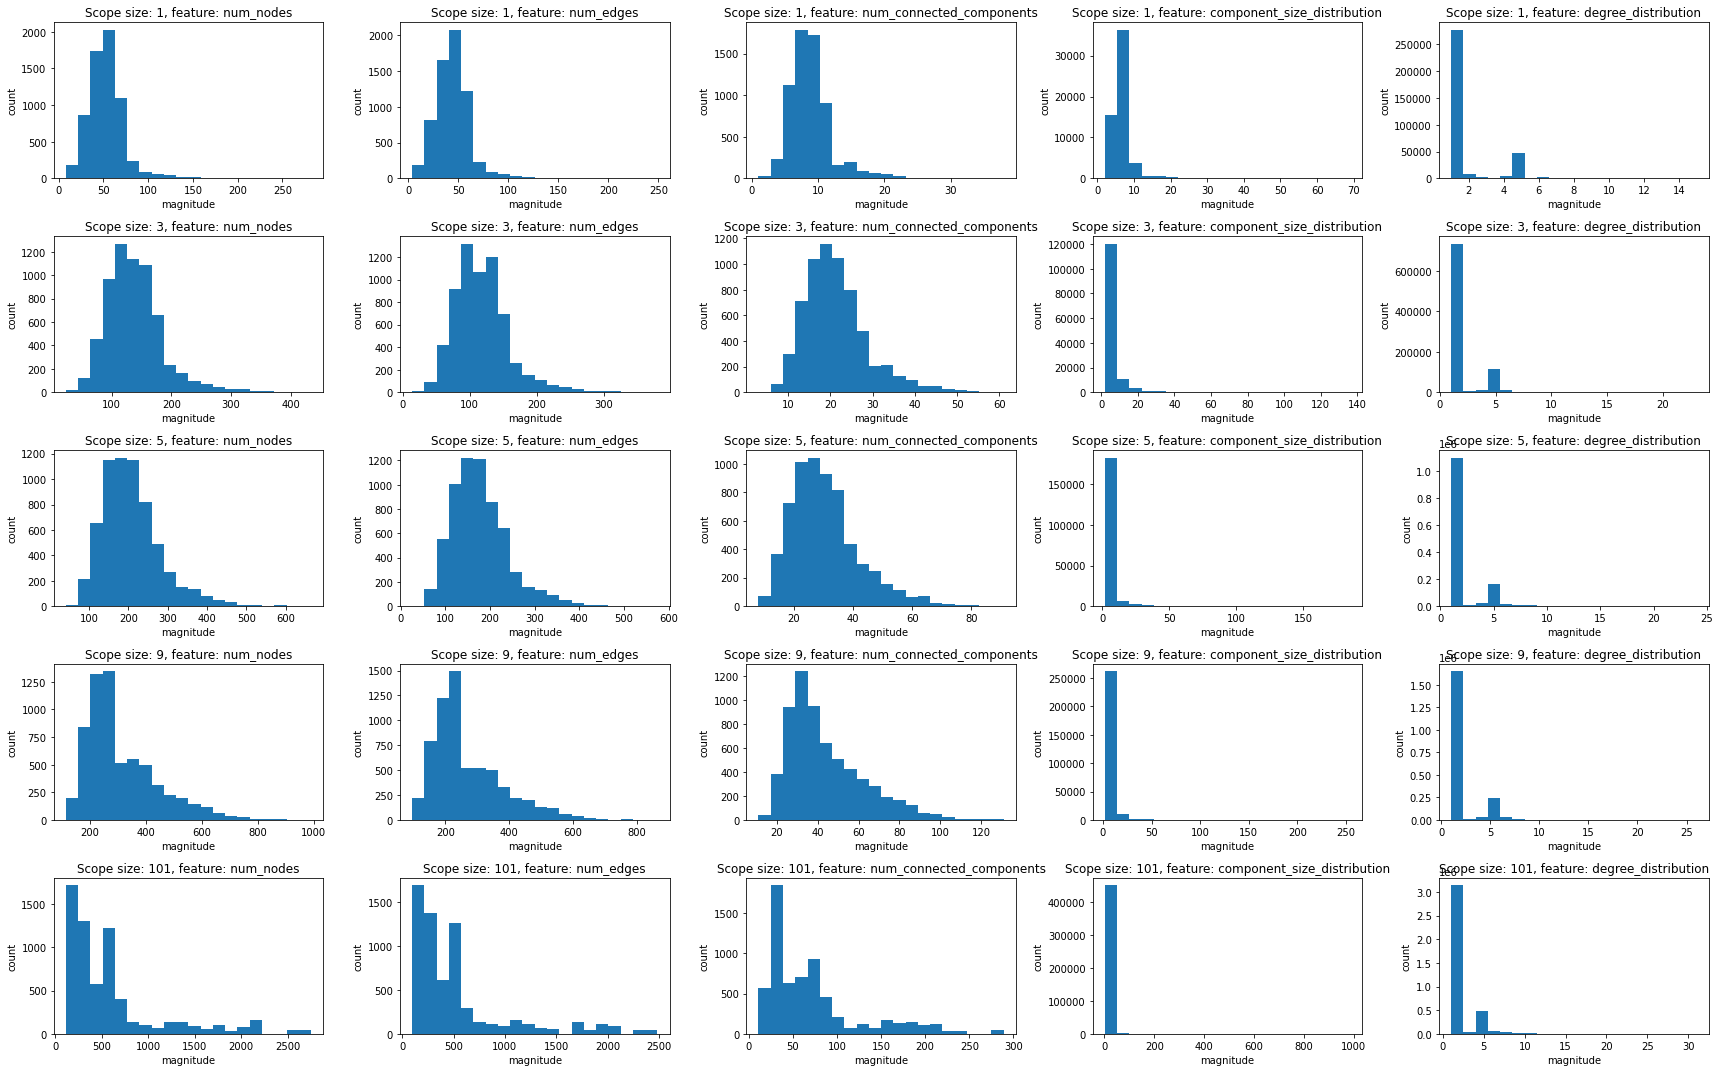

In [5]:
features = list(accumulated_simple_graph_statistics[1]["all"].keys())
features.remove("num_graphs")

num_scopes = len(scope_sizes)
num_features = len(features)
num_folders = len(fact_linking_data_files.items())


num_bins = 20
matplotlib.rcParams['figure.figsize'] = [24, 15]
fig, axs = plt.subplots(num_scopes, num_features)
for ridx, scope_size in enumerate(scope_sizes):
    for cidx, feature in enumerate(features):
        axs[ridx, cidx].hist(accumulated_simple_graph_statistics[scope_size]["all"][feature], bins=num_bins)
        axs[ridx, cidx].set_title(f"Scope size: {scope_size}, feature: {feature}")

for ax in axs.flat:
    ax.set(xlabel="magnitude", ylabel="count")

fig.tight_layout()
plt.show()

### Overall statistics about augmented graphs

- The statistics of augmented graphs are similar to the once of simple graphs. The main difference is that augmented graphs have more edges and that the majority of nodes has degree 4. This makes sense considering the construction of augmented graphs and ComFact dataset.
- The great majority of graphs is pretty small so there are no computational restrictions, no matter the scope size (there are only a few big ones if the whole conversation is considered at once).
- The graphs are sparse and consist of many small connected components (most components have up to 20 nodes).
- When determining the scope size, we should be careful to get big enough contexts, while controlling the amount of information that is duplicated (graphs of context of two adjacent utterances are almost the same). With this in mind, I would suggest using scope size of 3 or 5 utterances. This is just an initial guess and different scope sizes should be tried experimentally since the analysis didn't reveal any outstanding choices.

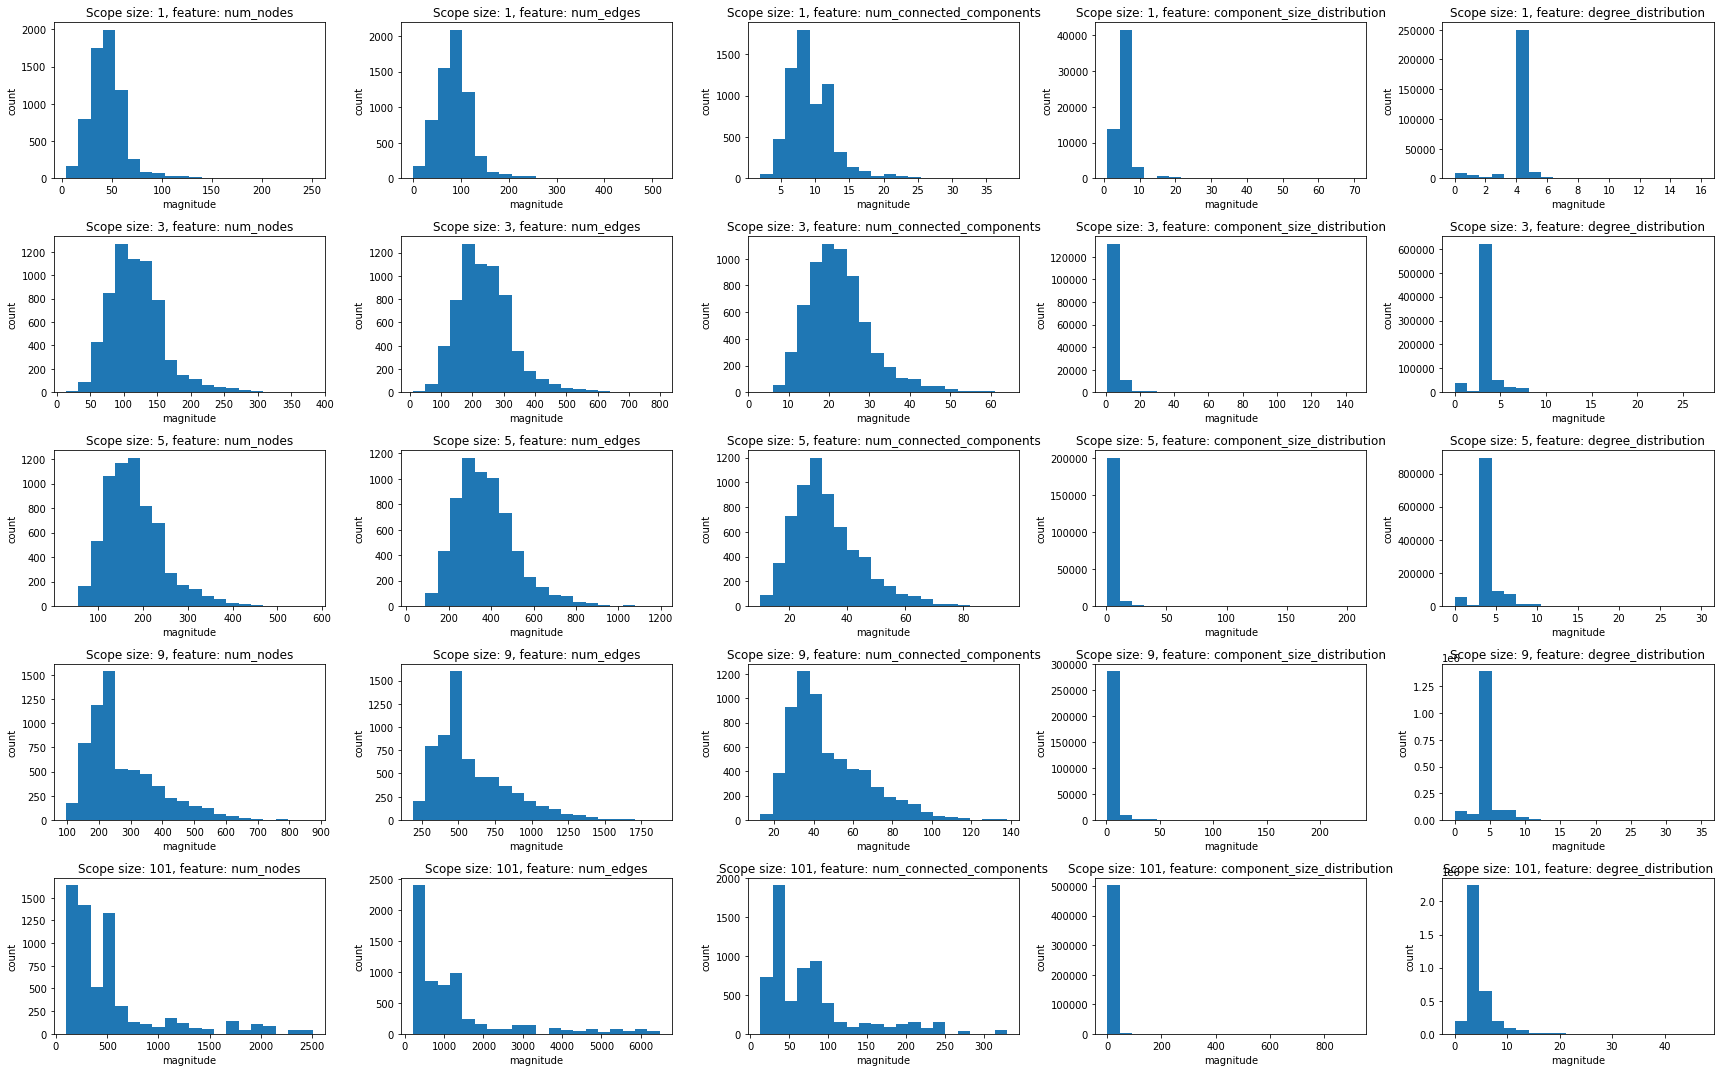

In [6]:
features = list(accumulated_augmented_graph_statistics[1]["all"].keys())
features.remove("num_graphs")

num_scopes = len(scope_sizes)
num_features = len(features)
num_folders = len(fact_linking_data_files.items())


num_bins = 20
matplotlib.rcParams['figure.figsize'] = [24, 15]
fig, axs = plt.subplots(num_scopes, num_features)
for ridx, scope_size in enumerate(scope_sizes):
    for cidx, feature in enumerate(features):
        axs[ridx, cidx].hist(accumulated_augmented_graph_statistics[scope_size]["all"][feature], bins=num_bins)
        axs[ridx, cidx].set_title(f"Scope size: {scope_size}, feature: {feature}")
    
for ax in axs.flat:
    ax.set(xlabel="magnitude", ylabel="count")

fig.tight_layout()
plt.show()

### Detailed statistics about simple graphs

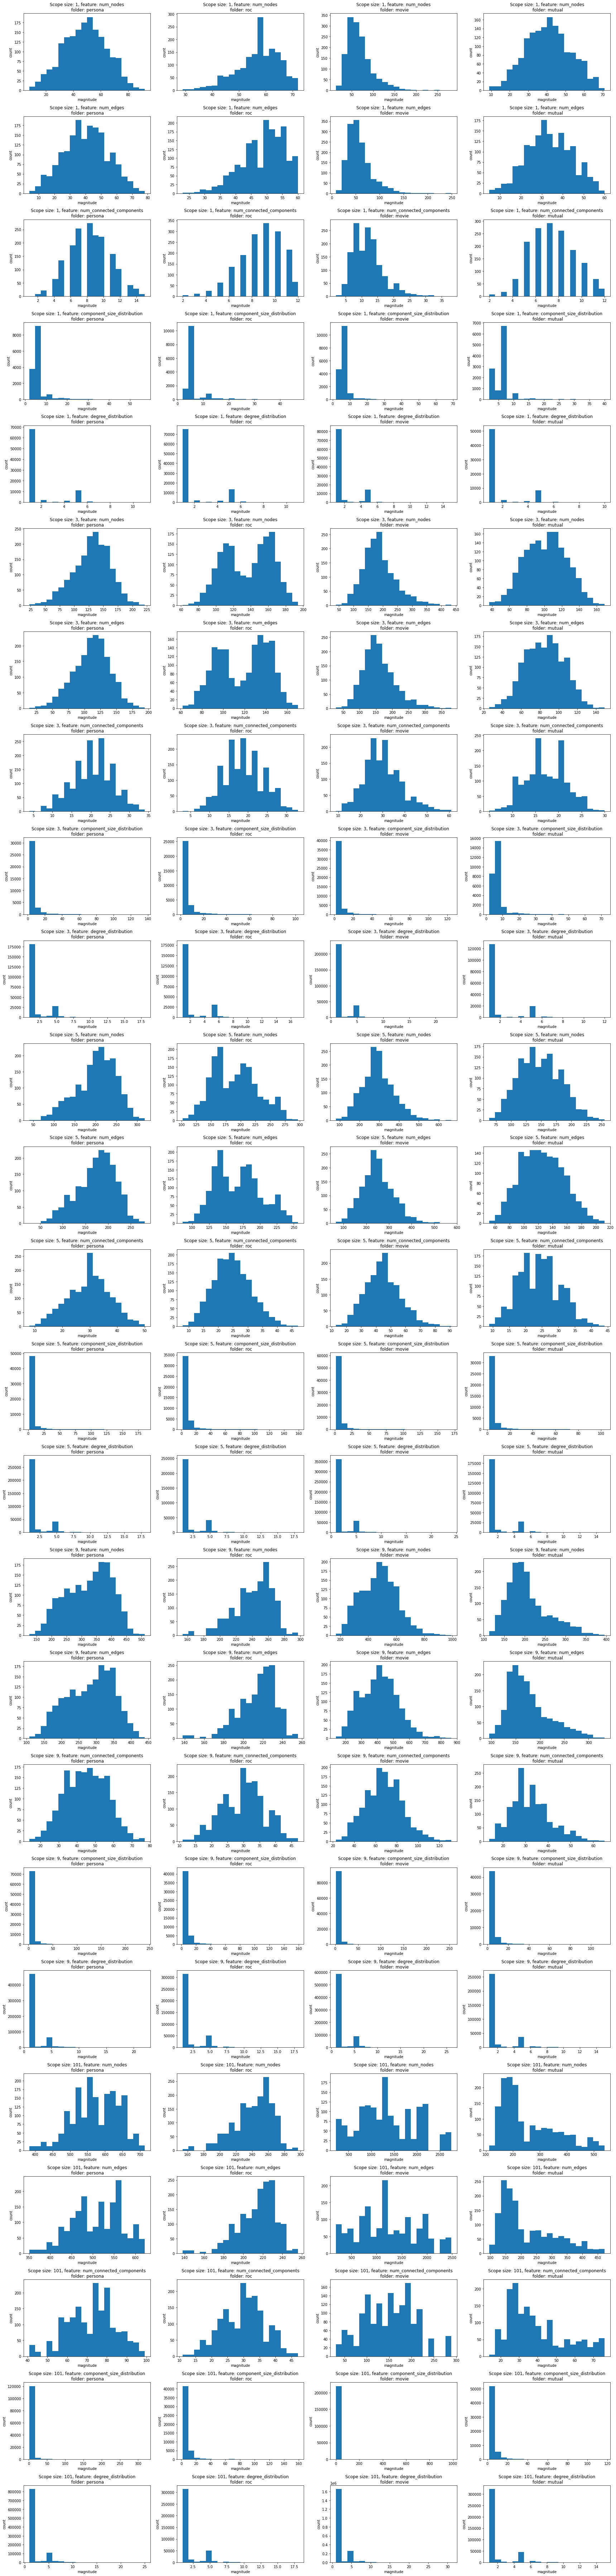

In [7]:
features = list(accumulated_simple_graph_statistics[1]["all"].keys())
features.remove("num_graphs")

num_scopes = len(scope_sizes)
num_features = len(features)
num_folders = len(fact_linking_data_files.items())


num_bins = 20
matplotlib.rcParams['figure.figsize'] = [24, 100]
fig, axs = plt.subplots(num_scopes * num_features, num_folders)
for sidx, scope_size in enumerate(scope_sizes):
    for fidx, feature in enumerate(features):
        for cidx, folder in enumerate(fact_linking_data_files.keys()):
            ridx = sidx * num_features + fidx
            axs[ridx, cidx].hist(accumulated_simple_graph_statistics[scope_size][folder][feature], bins=num_bins)
            axs[ridx, cidx].set_title(f"Scope size: {scope_size}, feature: {feature}\n folder: {folder}")
    
for ax in axs.flat:
    ax.set(xlabel="magnitude", ylabel="count")

fig.tight_layout()
plt.show()

### Detailed statistics about augmented graphs

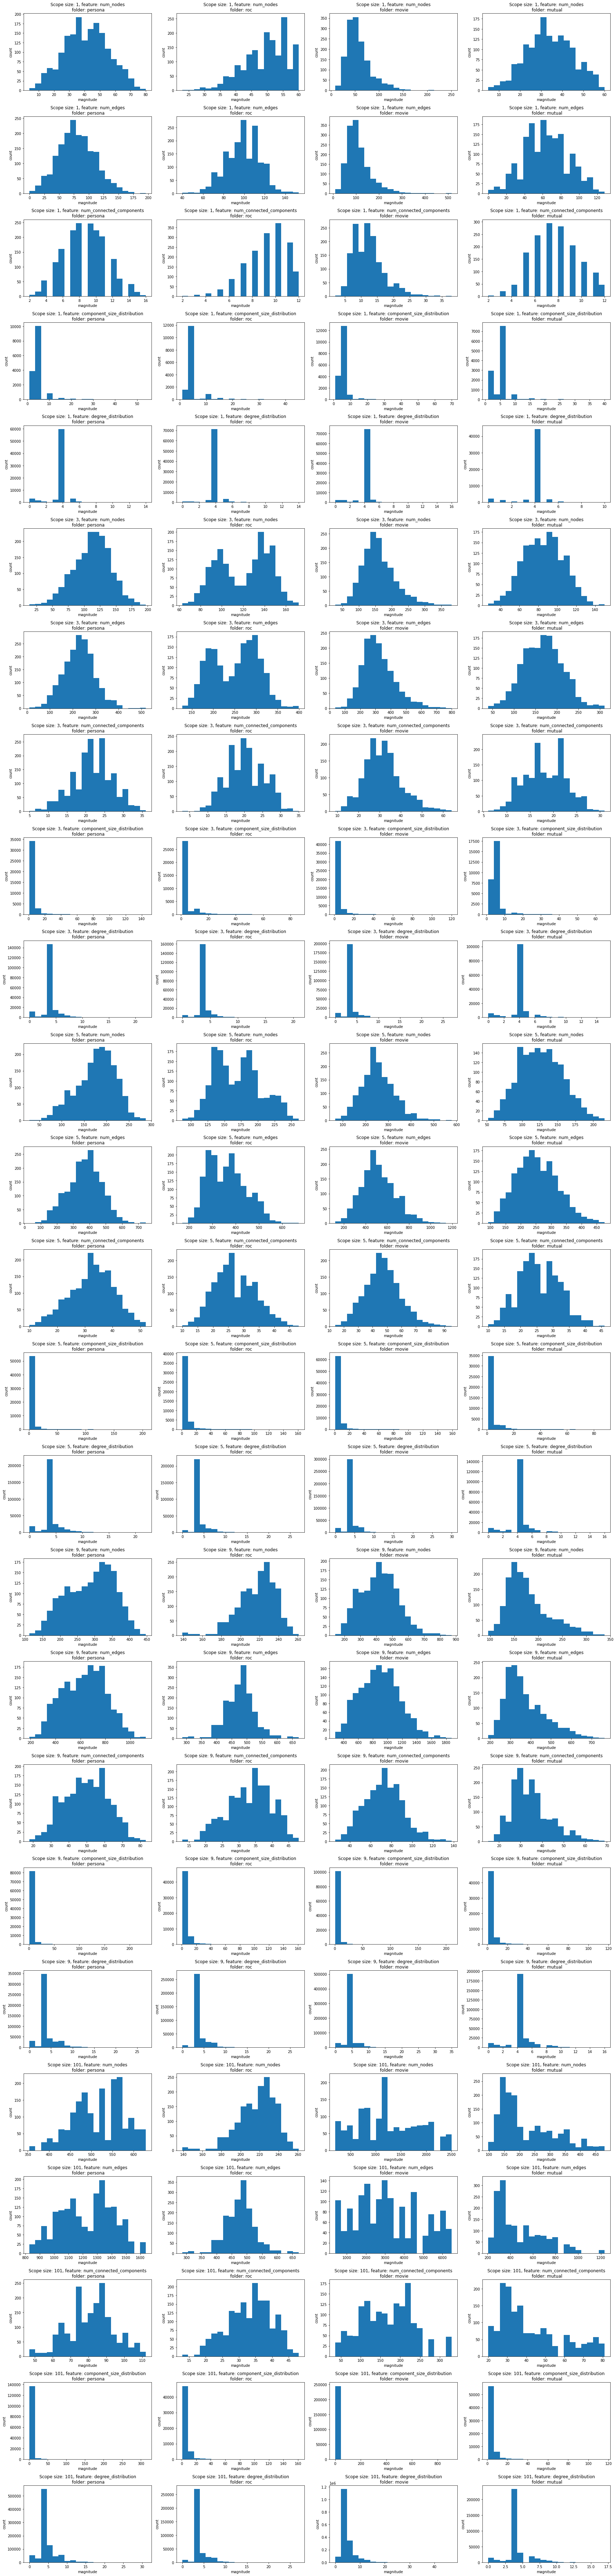

In [8]:
features = list(accumulated_augmented_graph_statistics[1]["all"].keys())
features.remove("num_graphs")

num_scopes = len(scope_sizes)
num_features = len(features)
num_folders = len(fact_linking_data_files.items())


num_bins = 20
matplotlib.rcParams['figure.figsize'] = [24, 100]
fig, axs = plt.subplots(num_scopes * num_features, num_folders)
for sidx, scope_size in enumerate(scope_sizes):
    for fidx, feature in enumerate(features):
        for cidx, folder in enumerate(fact_linking_data_files.keys()):
            ridx = sidx * num_features + fidx
            axs[ridx, cidx].hist(accumulated_augmented_graph_statistics[scope_size][folder][feature], bins=num_bins)
            axs[ridx, cidx].set_title(f"Scope size: {scope_size}, feature: {feature}\n folder: {folder}")
    
for ax in axs.flat:
    ax.set(xlabel="magnitude", ylabel="count")

fig.tight_layout()
plt.show()